# Progress projections, immunity, ICU demand for COVID 19.
> Estimating and projecting current and future percentage immunity per country, current and future need for ICUs beds, total cases from deaths, and cases and deaths per 100k.

- comments: true
- categories: [overview]
- author: artdgn
- image: images/covid-progress-projections.png
- permalink: /covid-progress-projections/
- toc: true
- hide: false

## What is this about?
1. **How bad is the impending medical crisis in different countries?**

  *Assuming that the bottleneck is the need for ICU beds, and assuming current infection rates.*

2. **How long will it take until substantial percentages of immunity (to start resuming normal life)?**

  *Assuming recovery implies immunity, assuming current infection rates, assuming no globally available vaccine or treatment in near future.*
  
> Note: Assumption of current infection rates is not to say that they won't be reduced, but to understand the implications of not reducing them. 

In [1]:
#hide
import pandas as pd
import overview_helpers

helper = overview_helpers.OverviewDataExtras
df = helper.filter_df(helper.table_with_projections())
df.columns

Index(['Cases.new', 'Cases.new.est', 'Cases.new.per100k',
       'Cases.new.per100k.est', 'Cases.total', 'Cases.total.est',
       'Cases.total.per100k', 'Cases.total.per100k.est', 'Continent',
       'Deaths.new', 'Deaths.new.per100k', 'Deaths.total',
       'Deaths.total.per100k', 'Fatality Rate', 'growth_rate', 'immune_ratio',
       'immune_ratio.est', 'immune_ratio.est.+14d', 'immune_ratio.est.+30d',
       'immune_ratio.est.+60d', 'immune_ratio.est.+7d',
       'immune_ratio.est.+90d', 'needICU.per100k', 'needICU.per100k.+14d',
       'needICU.per100k.+30d', 'needICU.per100k.+60d', 'needICU.per100k.+7d',
       'needICU.per100k.+90d', 'population', 'testing_bias'],
      dtype='object')

## Top 20 by estimated need for ICU beds
- ICU need is estimated as 6% of active cases.
- Estimation for current case numbers is done from deaths (details at the bottom).
- Testing bias ratio is the estimated ratio of testing coverage to testing coverage in countries where testing was comprehensive (details at the bottom).
- Growth rate is estimated from last 5 days data by weighted average of daily case growth rates.
- Actively sick ratios are taken from the SIR model (which is initialised with case numbers estimated from reported deaths, and estimated growth rate from last 5 days).
> Note: Projected figures are speculative due to assuming unchanging infection rate. In reality infection rates will go down with stricter isolation policies.

In [2]:
#hide_input
rename_cols = {'needICU.per100k': 'Estimated <br> Current need <br> per 100k',
               'needICU.per100k.+14d': 'Projected <br> In 14 days', 
               'needICU.per100k.+30d': 'Projected <br> In 30 days',               
               'Deaths.new.per100k': 'New deaths <br> per 100k <br> in 5 days',
               'growth_rate': 'Estimated <br> case growth <br> daily rate',
               'testing_bias': 'Estimated <br> testing <br> bias ratio <br> from deaths',
              }
icu_cols = list(rename_cols.values())[:3]
df_icu_bars = df.rename(rename_cols, axis=1)
df_icu_bars.sort_values(rename_cols['needICU.per100k'], ascending=False)\
[rename_cols.values()]\
.head(20).style\
    .bar(subset=icu_cols[0], color='#f43d64', vmin=0, vmax=10)\
    .bar(subset=icu_cols[1], color='#ef8ba0', vmin=0, vmax=10)\
    .bar(subset=icu_cols[2], color='#e0c5cb', vmin=0, vmax=10)\
    .bar(subset=[rename_cols['Deaths.new.per100k']], color='#340849', vmin=0, vmax=10)\
    .applymap(lambda _: 'color: red', subset=[rename_cols['Deaths.new.per100k']])\
    .bar(subset=[rename_cols['growth_rate']], color='#d65f5f', vmin=0, vmax=1)\
    .bar(subset=[rename_cols['testing_bias']], color='#fcc374', vmin=1, vmax=20)\
    .format('<b>{:.1%}</b>', subset=[rename_cols['growth_rate']])\
    .format('<b>{:.1f}</b>', subset=[rename_cols['testing_bias']])\
    .format('<b>{:.2}</b>', subset=[rename_cols['Deaths.new.per100k']])\
    .format('<b>{:.2f}</b>', subset=icu_cols)\
    .set_precision(2)

,Estimated Current need per 100k,Projected In 14 days,Projected In 30 days,New deaths per 100k in 5 days,Estimated case growth daily rate,Estimated testing bias ratio from deaths
Country/Region,,,,,,
Spain,0.96,3.03,7.67,8.7,11.8%,17.9
Italy,0.68,1.16,2.08,6.8,6.4%,13.1
US,0.66,5.51,54.15,0.62,18.8%,6.0
France,0.33,1.18,4.72,2.6,11.8%,12.4
United Kingdom,0.24,1.79,13.52,1.4,17.6%,16.4
Iran,0.17,0.45,1.36,0.81,8.9%,8.5
Netherlands,0.10,0.38,1.64,3.0,12.5%,13.7
Belgium,0.08,0.61,3.41,2.9,18.4%,10.1
Turkey,0.08,2.36,38.36,0.13,31.0%,9.1


## Top 20 by estimated immunisation progress 
- "*Immune*" here means "not susceptible" from [SIR model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model): previously infected (recovered / dead / actively ill). This assumes that recovery means immunity (details at the bottom). 
- Sorted by number of estimated new cases.


In [3]:
#hide_input
rename_cols = {'immune_ratio': 'Reported <br> Immune <br> currently', 
               'immune_ratio.est': 'Estimated <br> Immune <br> currently', 
               'immune_ratio.est.+14d': 'Projected <br> In 14 days', 
               'immune_ratio.est.+30d': 'Projected <br> In 30 days',
               'Fatality Rate': 'Reported <br> fatality <br> percentage',
               'growth_rate': 'Estimated <br> case growth <br> daily rate',
              }
progress_cols = list(rename_cols.values())[:4]
df_progress_bars = df.rename(rename_cols, axis=1)
df_progress_bars.sort_values('Cases.new.est', ascending=False)\
[rename_cols.values()]\
.head(20).style\
    .bar(subset=progress_cols[0], color='#279931', vmin=0, vmax=1.0)\
    .bar(subset=progress_cols[1], color='#5dad64', vmin=0, vmax=1.0)\
    .bar(subset=progress_cols[2], color='#719974', vmin=0, vmax=1.0)\
    .bar(subset=progress_cols[3], color='#a1afa3', vmin=0, vmax=1.0)\
    .bar(subset=[rename_cols['Fatality Rate']], color='#420412', vmin=0, vmax=0.1)\
    .applymap(lambda _: 'color: red', subset=[rename_cols['Fatality Rate']])\
    .bar(subset=[rename_cols['growth_rate']], color='#d65f5f', vmin=0, vmax=1)\
    .set_precision(2).format('<b>{:.1%}</b>', subset=list(rename_cols.values()))

,Reported Immune currently,Estimated Immune currently,Projected In 14 days,Projected In 30 days,Reported fatality percentage,Estimated case growth daily rate
Country/Region,,,,,,
Spain,0.2%,3.4%,12.7%,40.4%,8.8%,11.8%
US,0.0%,0.3%,2.6%,27.7%,1.8%,18.8%
Italy,0.2%,2.2%,5.0%,10.8%,11.4%,6.4%
France,0.1%,0.9%,3.4%,15.1%,6.7%,11.8%
United Kingdom,0.0%,0.5%,4.2%,35.6%,6.3%,17.6%
Iran,0.0%,0.4%,1.2%,3.8%,6.6%,8.9%
Turkey,0.0%,0.1%,3.7%,79.3%,1.6%,31.0%
Netherlands,0.1%,0.9%,4.1%,19.5%,7.3%,12.5%
Belgium,0.1%,1.0%,8.4%,57.2%,4.3%,18.4%


## Full table with more details
 - Contains reported data, estimations, projections, and numbers relative to population.
 - This is a busy table in order to present as many stats as possible for each country for people to be able to inspect their counties of interest in maximum amount detail (without running the code).
 - Sorted by projected need for ICU beds per 100k in 14 days. 
 - **New** in this table means **during last 5 days**.
 - Includes only countries with at least 10 deaths.
 > Tip: use Ctrl + F to find your country of interest in the table.

In [4]:
#hide_input
pretty_cols = {}

pretty_cols['deaths'] = 'Deaths <br> - Reported (+new) <br> - Per100k (+new) '
df[pretty_cols['deaths']] =(df.apply(lambda r: f" \
                         {r['Deaths.total']:,.0f} \
                         (+<b>{r['Deaths.new']:,.0f}</b>) <br> \
                         Per 100k: {r['Deaths.total.per100k']:,.1f} \
                         (+<b>{r['Deaths.new.per100k']:,.1f}</b>) \
                         ", axis=1))

pretty_cols['cases'] = 'Cases <br> - Reported (+new) <br> - Estimated (+new) '
df[pretty_cols['cases']] =(df.apply(lambda r: f" \
                         {r['Cases.total']:,.0f} \
                         (+<b>{r['Cases.new']:,.0f}</b>) <br>\
                         Est: {r['Cases.total.est']:,.0f} \
                         (+<b>{r['Cases.new.est']:,.0f}</b>)\
                         ", axis=1))

pretty_cols['icu'] = ('Estimated <br> Need for ICU <br> per 100k <br>\
                      - Current <br> - (in 14/30/60 days)')
df[pretty_cols['icu']] =(df.apply(lambda r: f"\
                        <b>{r['needICU.per100k']:.2f}</b> <br>\
                        ({r['needICU.per100k.+14d']:.1f} / \
                        {r['needICU.per100k.+30d']:.1f} / \
                        {r['needICU.per100k.+60d']:.1f}) \
                        ", axis=1))

pretty_cols['progress'] = ('Immunized <br> percentage <br> \
                      - Reported (Estimated) <br> - (in 14/30/60 days)')
df[pretty_cols['progress']] =(df.apply(lambda r: f" \
                        {r['immune_ratio']:.2%} \
                        <b>({r['immune_ratio.est']:.2%})</b> <br>\
                        ({r['immune_ratio.est.+14d']:.1%} / \
                        {r['immune_ratio.est.+30d']:.1%} / \
                        {r['immune_ratio.est.+60d']:.1%})", axis=1))

df.sort_values('needICU.per100k.+14d', ascending=False)\
    [pretty_cols.values()]\
    .style.set_na_rep("-").set_properties(**{})

,Deaths - Reported (+new) - Per100k (+new),Cases - Reported (+new) - Estimated (+new),Estimated Need for ICU per 100k - Current - (in 14/30/60 days),Immunized percentage - Reported (Estimated) - (in 14/30/60 days)
Country/Region,,,,
US,"2,978 (+2,036) Per 100k: 0.9 (+0.6)","161,807 (+96,029) Est: 965,678 (+573,109)",0.66 (5.5 / 54.2 / 64.7),0.05% (0.29%) (2.6% / 27.7% / 95.4%)
Spain,"7,716 (+4,069) Per 100k: 16.5 (+8.7)","87,956 (+38,441) Est: 1,572,889 (+687,428)",0.96 (3.0 / 7.7 / 6.6),0.19% (3.36%) (12.7% / 40.4% / 82.5%)
Turkey,168 (+109) Per 100k: 0.2 (+0.1),"10,827 (+8,394) Est: 98,613 (+76,453)",0.08 (2.4 / 38.4 / 10.9),0.01% (0.12%) (3.7% / 79.3% / 99.9%)
United Kingdom,"1,411 (+945) Per 100k: 2.1 (+1.4)","22,453 (+12,813) Est: 367,834 (+209,908)",0.24 (1.8 / 13.5 / 12.0),0.03% (0.54%) (4.2% / 35.6% / 95.1%)
France,"3,030 (+1,697) Per 100k: 4.6 (+2.6)","45,170 (+19,570) Est: 561,891 (+243,440)",0.33 (1.2 / 4.7 / 12.1),0.07% (0.86%) (3.4% / 15.1% / 68.9%)
Italy,"11,591 (+4,088) Per 100k: 19.2 (+6.8)","101,739 (+27,353) Est: 1,329,476 (+357,436)",0.68 (1.2 / 2.1 / 4.5),0.17% (2.20%) (5.0% / 10.8% / 30.4%)
Belgium,513 (+335) Per 100k: 4.4 (+2.9),"11,899 (+6,962) Est: 119,853 (+70,125)",0.08 (0.6 / 3.4 / 1.6),0.10% (1.03%) (8.4% / 57.2% / 97.1%)
Iran,"2,757 (+680) Per 100k: 3.3 (+0.8)","41,495 (+14,478) Est: 352,583 (+123,020)",0.17 (0.4 / 1.4 / 7.3),0.05% (0.42%) (1.2% / 3.8% / 24.5%)
Netherlands,865 (+508) Per 100k: 5.0 (+3.0),"11,817 (+5,379) Est: 161,744 (+73,624)",0.10 (0.4 / 1.6 / 3.3),0.07% (0.94%) (4.1% / 19.5% / 77.0%)


## Assumptions and references
- I'm not an epidemiologist. This is an attempt to understand what's happening, and what the future looks like if current trends remain unchanged.
- Everything is approximated and depends heavily on underlying assumptions.
- Immunisation:
    - "*Immune*" and "*Immunisation*" here means "not susceptible" from [SIR model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model): previously infected (recovered / dead / actively ill). 
    - This also assumes that recovery means immunity from the virus. This is a reasonable assumption (for a particular strain) because at least currently the patient's immune system is the main mechanism by which the infection is removed.
    - This will not hold true if there are multiple strains for which immunity needs to be developed independently (like in the case of flu or the common cold).    
- Total case estimation is done from deaths by:
    - Assuming that unbiased fatality rate is 1.5% (from heavily tested countries / the cruise ship data) and that it takes 8 days on average for a case to go from being confirmed positive (after incubation + testing lag) to death. This is the same figure used by ["Estimating The Infected Population From Deaths"](https://covid19dashboards.com/covid-infected/) in this repo.
    - Testing bias: the actual lagged fatality rate is than divided by the 1.5% figure to estimate the testing bias in a country. The estimated testing bias then multiplies the reported case numbers to estimate the *true* case numbers (*=case numbers if testing coverage was as comprehensive as in the heavily tested countries*).
    - The testing bias calculation is a high source of uncertainty in all these estimations and projections. Better source of testing bias (or just *true case* numbers), should make everything more accurate.
- Projection is done using a simple [SIR model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model) with (examples below) combined with the approach in [Total Outstanding Cases](https://covid19dashboards.com/outstanding_cases/#Appendix:-Methodology-of-Predicting-Recovered-Cases):
    - Growth rate calculated over the 5 past days. This is pessimistic - because it includes the testing rate growth rate as well, and is slow to react to both improvements in test coverage and "flattening".
    - Recovery probability being 1/20 (for 20 days to recover) where the rate estimated from [Total Outstanding Cases](https://covid19dashboards.com/outstanding_cases/#Appendix:-Methodology-of-Predicting-Recovered-Cases) is too high (on down-slopes).
- ICU need is calculated as being [6% of active cases](https://medium.com/@joschabach/flattening-the-curve-is-a-deadly-delusion-eea324fe9727) where:
    - Active cases are taken from the SIR model.
    - This is both pessimistic - because real ICU rate may in reality be lower, due to testing biases, and especially in "younger" populations), and optimistic - because active cases which are on ICU take longer (so need the ICUs for longer).
    - [Some numbers](https://www.forbes.com/sites/niallmccarthy/2020/03/12/the-countries-with-the-most-critical-care-beds-per-capita-infographic/) on actual capacity of ICUs per 100k (didn't find a full dataset for a lot of countries yet).

### Examples of SIR model plots
- The purpose is to demonstrate the calculations.
- For countries that ranked highest in: estimated new cases, projected need for ICU in 14 days, projected immunisation percentage in 14 days.

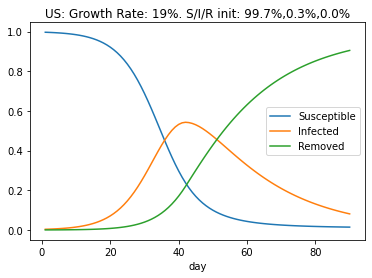

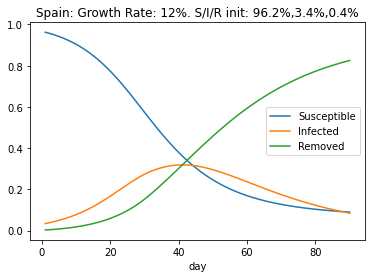

In [5]:
#hide_input
sir_plot_countries = df[['needICU.per100k.+14d', 
                         'Cases.new.est', 
                         'immune_ratio.est.+14d']].idxmax().unique()
helper.table_with_projections(plot_countries=sir_plot_countries);